In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
import gget
import sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import matrix as matrix

# Load Population Pore-C Data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


read_code,65057,21695,119867,7453,65998,81009,110088,18720,89300,115287,...,47296,6202,3069,97901,6136,88389,111230,69764,94327,2373
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Apc.shape=(193, 193)


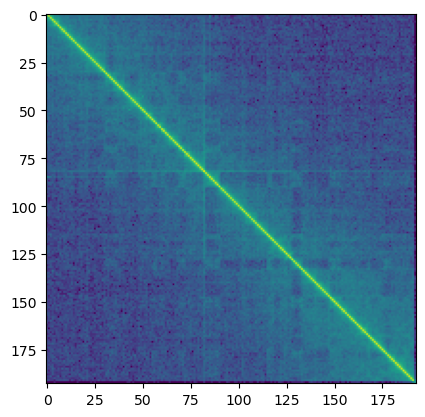

In [3]:
Apc = matrix.clique_expand_incidence(df, zero_diag=False) 
Apc = Apc.sort_index(axis=1)
Apc = Apc.sort_index(axis=0)
Apc = Apc.to_numpy()

print(f"{Apc.shape=}")
plt.imshow(np.log1p(Apc))

# Load Population Hi-C Data

Ahc.shape=(196, 196)
Ahc.shape=(193, 193)


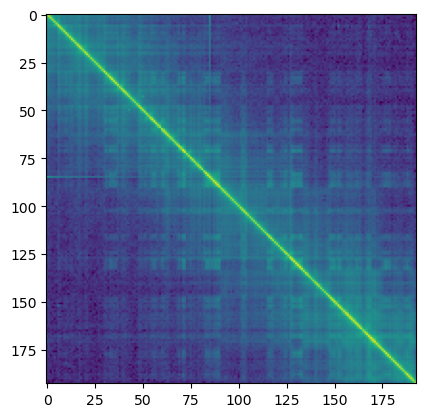

In [4]:
# compare against population Hi-C
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_hic/chr1_1000000.parquet"

hic = pd.read_parquet(fpath)
Ahc = hic.to_numpy()
print(f"{Ahc.shape=}")

# drop the telomere
Ahc = Ahc[3:, :][:, 3:]
print(f"{Ahc.shape=}")

plt.imshow(np.log1p(Ahc))

In [5]:
print(f"Number of Contacts (Pore-C) {Apc.sum().sum()}")
print(f"Number of Contacts (Hi-C) {Ahc.sum().sum()}")

print(f"Density (Pore-C) {Apc.astype(bool).sum() / Apc.size:.4f}")
print(f"Density (Hi-C) {Ahc.astype(bool).sum() / Ahc.size:.4f}")

Number of Contacts (Pore-C) 899425.0
Number of Contacts (Hi-C) 14205081
Density (Pore-C) 0.9924
Density (Hi-C) 0.9966


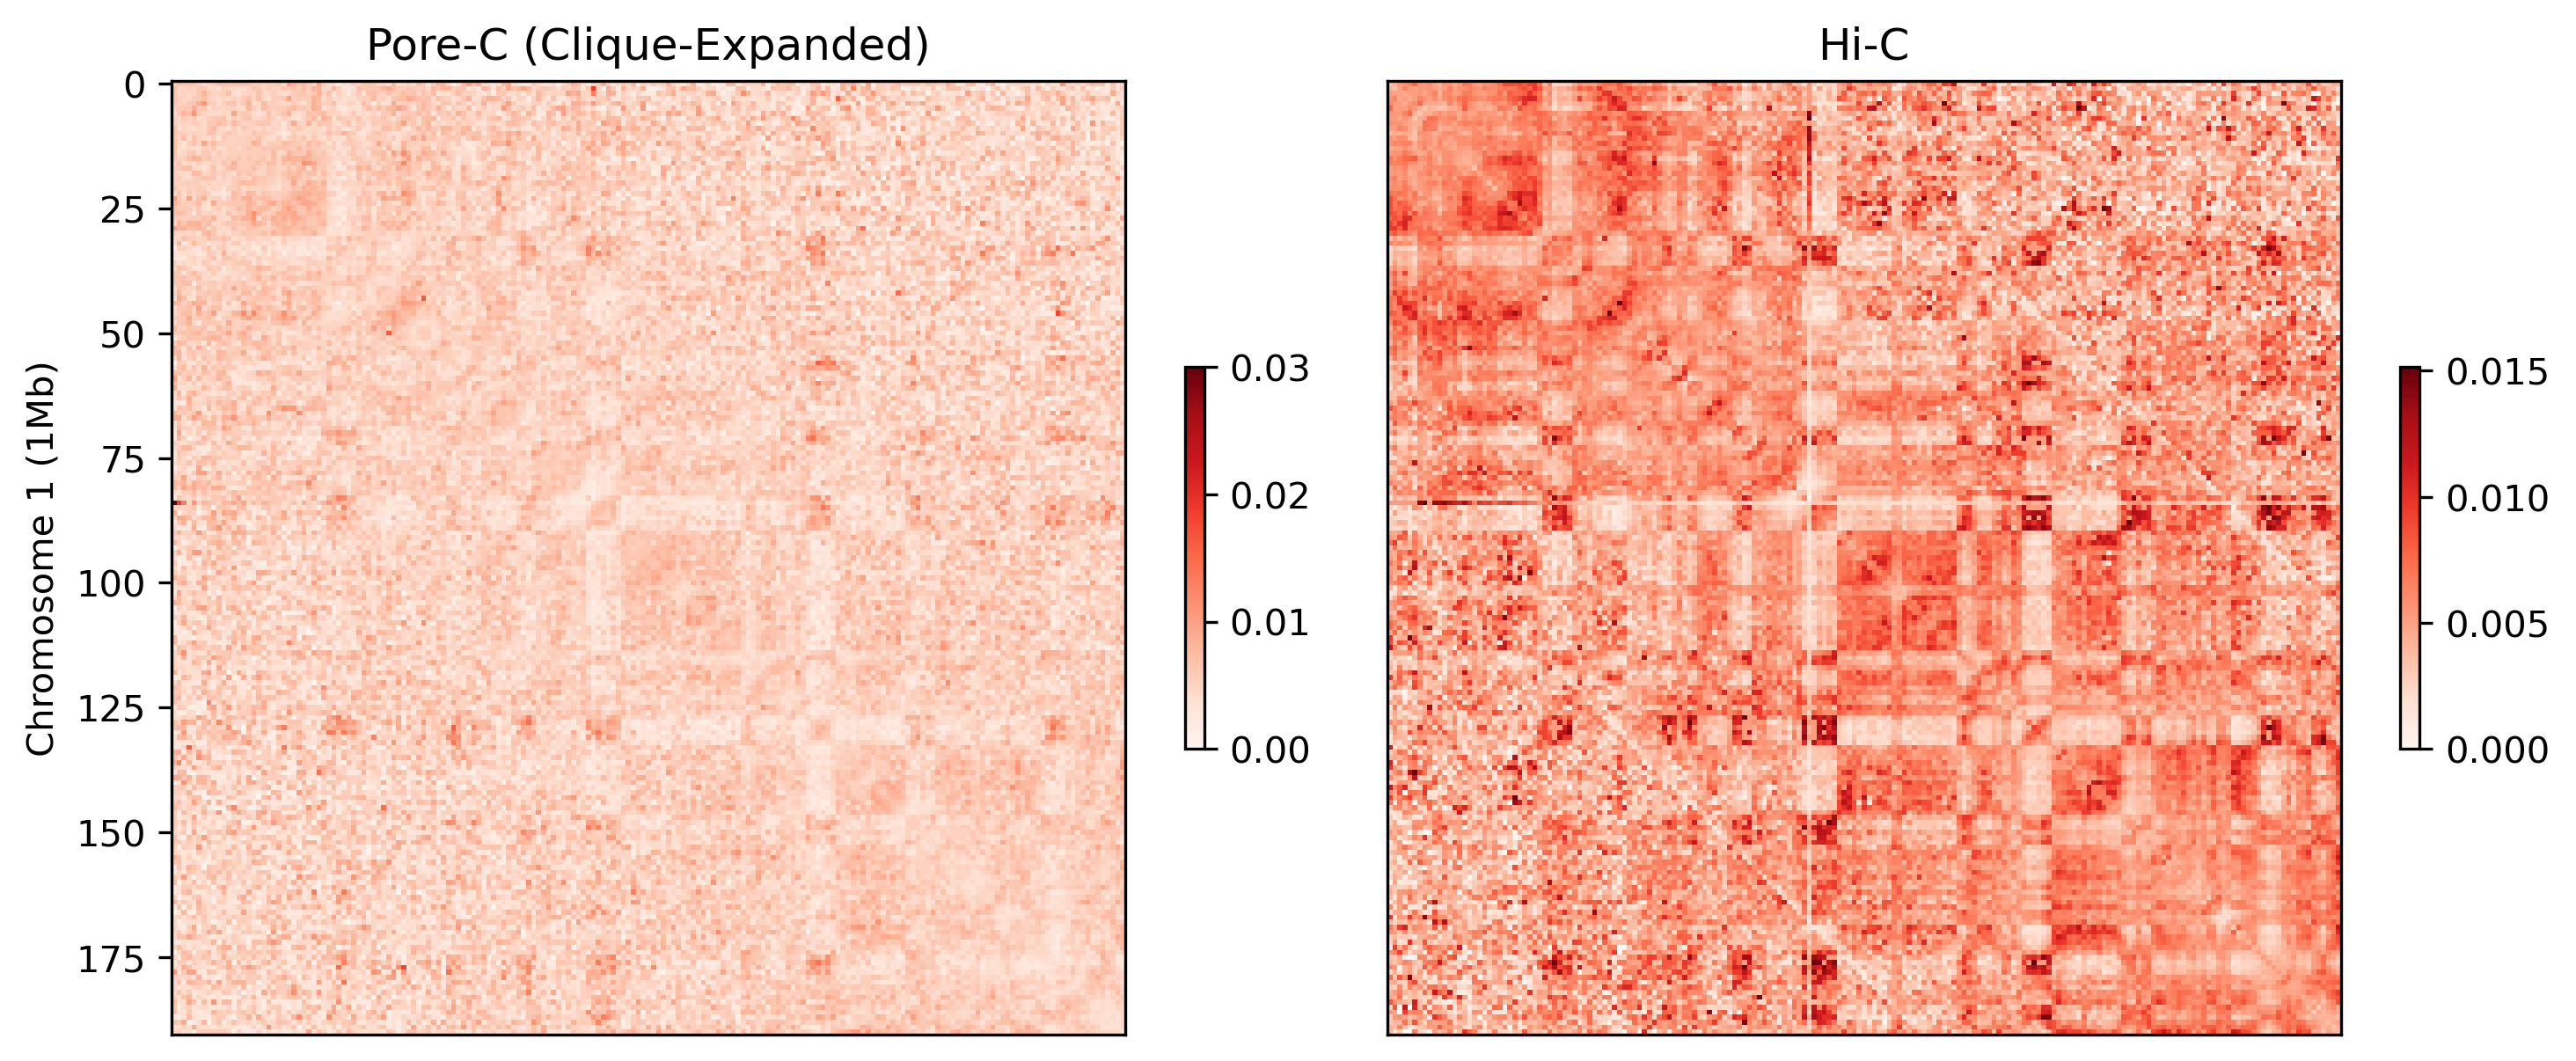

In [9]:
def normalize_and_correct(A, top=20):
    """
    Normalizes a matrix using Kronecker and OE normalization, then corrects outliers
    in the upper triangle.

    Args:
        Ahc: The original matrix to be processed.
        top: The number of top outliers to correct (default is 20).

    Returns:
        The normalized matrix with corrected outliers.
    """
    # Apply OE normalization
    A_norm = matrix.normalize_kr(matrix.normalize_oe(A)).todense()

    # Correct outliers in the upper triangle
    row_idx, col_idx = matrix.get_sorted_upper_triangle_indices(A_norm)
    for i in range(top):
        A_norm[row_idx[i], col_idx[i]] = A_norm.mean()

    return A_norm

Apc_trunc = matrix.remove_indices(Apc, [84, 192])
Ahc_trunc = matrix.remove_indices(Ahc, [84, 192])

Apc_norm = normalize_and_correct(Apc_trunc, top=1)
Ahc_norm = normalize_and_correct(Ahc_trunc, top=100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4

fig, axs = plt.subplots(1, 2)

im1 = axs[0].imshow(Apc_norm, cmap='Reds')
im2 = axs[1].imshow(Ahc_norm, cmap='Reds')

# Add colorbars for each subplot (positioned to the right of the plot)
cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.4)  
cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.4)  

axs[0].set_title('Pore-C (Clique-Expanded)')
axs[1].set_title('Hi-C')

axs[0].set_ylabel("Chromosome 1 (1Mb)")

axs[1].set_yticks([])
axs[0].set_xticks([])
axs[1].set_xticks([])

plt.tight_layout()

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:


sns.heatmap(Apc,
            square=True)

In [ ]:
dpath = "/scratch/indikar_root/indikar1/shared_data/population_pore_c/align_table/"

df = []
for f in os.listdir(dpath):
    if not 'parquet' in f:
        continue

    fpath = f"{dpath}{f}"
    tmp = pd.read_parquet(fpath)
    print(f, tmp.shape)
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
df.head()

In [ ]:
def filter_and_prepare_data(df, resolution, mapq=60):
    """Filters and prepares contact data for analysis.

    Args:
        df (pd.DataFrame): The raw DataFrame containing contact data.
        resolution (int): The desired genomic resolution for binning.
        mapq (int, optional): The minimum mapping quality to filter by. Defaults to 60.

    Returns:
        pd.DataFrame: The filtered and processed DataFrame.
    """
    # Filtering
    filtered_df = df[df['mapping_quality'] >= mapq].copy()  # Filter by MAPQ
    filtered_df = filtered_df[filtered_df['fragment_id'].notna()] 

    # Binning
    filtered_df['bin'] = filtered_df['ref_start'].apply(lambda x: ut.bin_loci(x, resolution))
    return filtered_df  

resolution = 1000000
# resolution = 100000
# mapq = 60
mapq = 1
resolution_str = ut.human_readable_bp(resolution)  
print(f"Binning at {resolution_str} with mapq == {mapq}")
pdf = filter_and_prepare_data(df, resolution, mapq=mapq)
print(f"{pdf.shape=}")
pdf.head()

In [ ]:
chrom = "1"
order_threshold = 2
sample_size = 1000

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=sample_size)

print(f"{I.shape=}")
I.head()

In [ ]:
reload(plt2)
reload(ut)

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 0.5,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.25,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(I), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.show()
A = matrix.clique_expand_incidence(I, zero_diag=False)   
print(f"{A.shape=}")
# plt.imshow(matrix.normalize_kr(A).todense())
# plt.xticks([])
# plt.show()

In [ ]:
break

In [ ]:
plt.spy(matrix.normalize_kr(A).todense())
plt.xticks([])
plt.show()

In [ ]:
u_i, s_i, vh_i = np.linalg.svd(I)
u_a, s_a, vh_a = np.linalg.svd(A)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.plot(s_i, lw=1, marker="o", markersize=2, label='Incidence')
plt.plot(s_a, lw=1, marker="+", markersize=2, label='Adjacency')
plt.legend()

plt.ylabel('Singular Value')
plt.xlabel('Singular Value Index')

In [ ]:
reload(ut)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.plot(ut.normalize_1d_array(s_i), lw=1, marker="o", markersize=2, label='Incidence')
plt.plot(ut.normalize_1d_array(s_a), lw=1, marker="+", markersize=2, label='Adjacency')
plt.legend()

plt.ylabel('Normalized Singular Value')
plt.xlabel('Singular Value Index')

In [ ]:
# break

# all chrom 1

In [ ]:
reload(ut)
chrom = "1"
order_threshold = 1

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=None)

Apc = ut.clique_expand_incidence(I, zero_diag=False)
print(f"{I.shape=} {Apc.shape=}")

In [ ]:
# plot the contact order of the population pore-c

degree = I.sum(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5
sns.histplot(x=degree, 
             discrete=True,
             stat='percent',
            )

plt.xticks(list(range(1, 15)))
plt.xlabel('Order (Unique 1Mb Bins)')


In [ ]:
# break

# load the pop hi-c

In [ ]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

chrom = "chr1"
clr = cooler.Cooler(f'{fpath}::resolutions/{resolution}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

# drop the telomere
Ahic = Ahic[3:, :][:, 3:]
print(f"{Ahic.shape=}")

# drop problematic indices

In [ ]:
reload(ut)

Apc = ut.remove_indices(Apc, [84, 85, 192])
Ahic = ut.remove_indices(Ahic, [84, 85, 192])

In [ ]:
print(f"{Apc.shape=}")
print(f"{Apc.sum()=}")
print(f"{Apc.mean()=:.3f}")
print(f"{Apc.max()=}")

print()
print(f"{Ahic.shape=}")
print(f"{Ahic.sum()=}")
print(f"{Ahic.mean()=:.3f}")
print(f"{Ahic.max()=}")

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(np.log1p(Apc))
axs[1].imshow(np.log1p(Ahic))

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [ ]:
break

In [ ]:
# normalized
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

Apc_norm = ut.normalize_oe(ut.normalize_kr(Apc).todense())
Ahic_norm = ut.normalize_oe(ut.normalize_kr(Ahic).todense())

print(f"{Apc_norm.shape=}")
print(f"{Ahic_norm.shape=}")

axs[0].imshow(Apc_norm)
axs[1].imshow(Ahic_norm)

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [ ]:
reload(ut)

top = 10
row_idx, col_idx = ut.get_sorted_upper_triangle_indices(Ahic_norm)
print(row_idx.shape, col_idx.shape)

plt.imshow(Ahic_norm)

for i in range(top):
    plt.scatter(row_idx[i], col_idx[i], s=1, c='r')

In [ ]:
# update the matrix 
for i in range(top):
    Ahic_norm[row_idx[i], col_idx[i]] = Ahic_norm.mean()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(Apc_norm)
axs[1].imshow(Ahic_norm)

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [ ]:
# break

In [ ]:
diff = Apc_norm - Ahic_norm
diff = diff - diff.mean()

plt.imshow(diff, cmap='RdYlGn')
plt.title(r"$A_{pc} - A_{hic}$")
plt.xticks([])

In [ ]:

def f_norm_submatrix_diff(matrix1, matrix2, n, sample_size=1):
    """Calculates the F-norm of the difference between randomly sampled submatrices.

    Args:
        matrix1 (np.ndarray): The first symmetric matrix.
        matrix2 (np.ndarray): The second symmetric matrix.
        n (int): The size of the submatrices to sample.
        sample_size (int, optional): Number of submatrix samples to take. Defaults to 1.

    Returns:
        list: A list containing:
            * float: The average F-norm over the sampled submatrices.
            * tuple: The average centroid coordinates (row, column) across samples. 
    """

    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")
    if not (np.allclose(matrix1, matrix1.T) and np.allclose(matrix2, matrix2.T)):
        raise ValueError("Matrices must be symmetric.")

    f_norms = []
    centroids = []
    for _ in range(sample_size):
        # Randomly select top-left corner of submatrices
        row_idx = np.random.randint(0, matrix1.shape[0] - n)
        col_idx = np.random.randint(0, matrix2.shape[1] - n)

        submatrix1 = matrix1[row_idx:row_idx + n, col_idx:col_idx + n]
        submatrix2 = matrix2[row_idx:row_idx + n, col_idx:col_idx + n]

        diff = submatrix1 - submatrix2
        f_norms.append(np.linalg.norm(diff, ord='fro')) 

        # Calculate centroid (center of mass)
        centroid = (row_idx + n//2, col_idx + n//2) 
        centroids.append(centroid)

    return f_norms, centroids

sample_size = 100000
submat = 15
f_norms, centroids = f_norm_submatrix_diff(Apc, Ahic, n=submat, sample_size=sample_size)

x, y = zip(*centroids)
s = plt.scatter(x, y, c=f_norms, s=1, ec='none', cmap='RdYlGn_r', alpha=0.4)
plt.scatter(y, x, c=f_norms, s=1, ec='none', cmap='RdYlGn', alpha=0.4)
plt.colorbar(s, label=r"$||A_{pc} - A_{hic}||_{F}$", shrink=0.75) 
plt.gca().set_aspect('equal')
plt.xticks([])
plt.gca().invert_yaxis()
plt.title("Local Differences")

In [ ]:
# break

In [ ]:
# row sums
deg_pc = np.array(Apc_norm.sum(axis=1)).ravel()
deg_hic = np.array(Ahic_norm.sum(axis=1)).ravel()

n = deg_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(deg_pc))
axs[1].bar(range(n), ut.normalize_1d_array(deg_hic))
axs[2].bar(range(n), ut.normalize_1d_array(deg_pc) - ut.normalize_1d_array(deg_hic))

axs[0].set_title('Pop Pore-C Degree')
axs[1].set_title('Pop Hi-C Degree')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(deg_pc, deg_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(deg_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(deg_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Degree')
plt.xlabel('Chrom 1 Loci (1Mb)')

In [ ]:
# diagonal
diag_pc = np.diag(Apc_norm)
diag_hic = np.diag(Ahic_norm)

n = diag_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(diag_pc))
axs[1].bar(range(n), ut.normalize_1d_array(diag_hic))
axs[2].bar(range(n), ut.normalize_1d_array(diag_pc) - ut.normalize_1d_array(diag_hic))

axs[0].set_title('Pop Pore-C Diagonal')
axs[1].set_title('Pop Hi-C Diagonal')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(diag_pc, diag_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(diag_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(diag_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Diagonal')
plt.xlabel('Chrom 1 Loci (1Mb)')

# principle eigenvectors

In [ ]:
vpc, wpc = np.linalg.eigh(Apc_norm)
vhic, whic = np.linalg.eigh(Ahic_norm)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
plt.plot(ut.normalize_1d_array(vpc[::-1]),  marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(vhic[::-1]), marker="+", markersize=2, lw=1, label='Hi-C')

plt.yscale('log')
plt.legend()

plt.ylabel('Normalized Eigenvalue (log)')
plt.xlabel('Eigenvalue Index')

In [ ]:
ab_pc = np.array(wpc[:, -1]).ravel()
ab_hic = np.array(whic[:, -1]).ravel()

ab_pc = ab_pc - ab_pc.mean()
ab_hic = ab_hic - ab_hic.mean()

n = ab_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].bar(range(n), ab_pc)
axs[1].bar(range(n), ab_hic)
# axs[2].bar(range(n), ab_pc - ab_hic)

axs[0].set_title('Pop Pore-C Eigenvector 1')
axs[1].set_title('Pop Hi-C Eigenvector 1')
# axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(ab_pc, ab_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
def sum_k_diagonals(matrix):
    """Calculates the sum of all k diagonals in a symmetric matrix.

    Args:
        matrix (np.ndarray): The input symmetric matrix.

    Returns:
        list: A list of sums, where each element represents the sum of a diagonal.
    """

    if not np.allclose(matrix, matrix.T):
        raise ValueError("Input matrix must be symmetric.")

    n = matrix.shape[0]
    result = []

    # Extract elements along each diagonal
    for i in range(n-1):
        diagonal = np.diag(matrix, k=i)
        row = {
            'distance' : i,
            'contacts' : np.sum(diagonal),
        }
        result.append(row)

    return pd.DataFrame(result)
        
        
res_pc = sum_k_diagonals(Apc)
res_hic = sum_k_diagonals(Ahic)

res_pc['normalized_contacts'] = res_pc['contacts'] / res_pc['contacts'].sum()
res_hic['normalized_contacts'] = res_hic['contacts'] / res_hic['contacts'].sum()

plt.rcParams['figure.dpi'] = 200

plt.rcParams['figure.figsize'] = 3, 3
plt.plot(res_pc['distance'],
         res_pc['normalized_contacts'], label='Pore-C')

plt.plot(res_hic['distance'],
         res_hic['normalized_contacts'], label='Hi-C')

plt.yscale('log')
plt.legend()
plt.ylabel('Normalized Contacts')
plt.xlabel('Contact Distance (Mb)')

In [ ]:
break

In [ ]:
plt.imshow(I)

In [ ]:
def clique_expand_incidence(I, zero_diag=True):
    """A function to clique expand an incidence matrix """
    node_list = I.index
    A = np.dot(I, I.T)
    if zero_diag:
        A = A - np.diag(np.diag(A))
    A = pd.DataFrame(A, columns=node_list,
                     index=node_list)
    return A
    
A = clique_expand_incidence(I)    
plt.imshow(A)

In [ ]:
A = np.dot(I, I.T)
A = A - np.diag(np.diag(A))
plt.imshow(A)

np.diag(A)

In [ ]:
def explicit_clique_expand(I):
    """A function to perform explicit clique-expansion 
    of an incidence matrix """
    n, h = I.shape
    node_list = I.index
    A = np.zeros((n , n))

    for h in I.columns:
        ind = np.argwhere(I[h] > 0).ravel()
        pairs = list(itertools.combinations(ind, 2))

        for i, j in pairs:
            A[i, j] += 1
            A[j, i] += 1

    return A
    

A_exp = explicit_clique_expand(I)
plt.imshow(A_exp)

In [ ]:
plt.imshow(A_exp - A)

In [ ]:
np.diag(A)

In [ ]:
np.diag(A_exp)

In [ ]:
break